In [ ]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#dependencies are in 1st cell

class standard_lstm():
  'an simple way to train/test an LSTM on a single assets price data'

  def __init__(self, ticker, interval='1m',start='2023-11-28', end='2023-11-29', window_size=5, model=[100,100,25,1], test_split=.8, epochs=5, optimizer='adam', loss='mean_squared_error', batch_size=1, plot=True):
    '''
        sets variables for the class

      Params:
        ticker:       (str) asset name via yahoo finance
        interval:     (str) interval of candlestick data via yahoo finance
        start:        (str) start date in form YYYY-MM-DD
        end:          (str) end date in form YYYY-MM-DD
        window_size:  (int) size of lstm lookback
        model:        (list) model wights for hardcoded model, or inputed own model as [None, model]
        test_split:   (float) float from 0-1, indicating a percent
        epochs:       (int) number of epcohs used for training
        optimizer:    (str) optimizer name, reference tensorflow
        loss:         (str) loss function, reference tensorflow
        batch_size:   (int) batch size for training
        plot:         (boolean) displays plot if true

    '''
    self.ticker = ticker
    self.interval = interval
    self.start = start
    self.end = end
    self.window_size = window_size
    self.model = model
    self.test_split = test_split
    self.epochs = epochs
    self.optimizer = optimizer
    self.loss = loss
    self.batch_size = batch_size
    self.plot_chart = plot
    self.data = self.standard_data()

    self.x_train, self.y_train, self.x_test, self.y_test, self.scaler, self.training_data_len = self.test_train()
# allows you to inject your own predefined model
    if self.model[0]==None:
      print(self.model[1].summary())
      self.build_model = self.model[1]
    else:
      self.build_model = self.build_model()

    self.trained_model = self.model_fit()
    self.predictions, self.rmse = self.model_predict()

    if self.plot_chart:
      self.plot()



  def standard_data(self):
    'gets data from yahoo finance'
    _data = yf.download(self.ticker, interval=self.interval,start=self.start, end=self.end)
    return _data


  def test_train(self):
    'test train split'
    close_prices = self.data['Close']
    values = close_prices.values
    training_data_len = math.ceil(len(values)* self.test_split)

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(values.reshape(-1,1))

    train_data = scaled_data[0: training_data_len, :]

    x_train = []
    y_train = []

    for i in range(self.window_size, len(train_data)):
        x_train.append(train_data[i-self.window_size:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    test_data = scaled_data[training_data_len-self.window_size: , : ]
    x_test = []
    y_test = values[training_data_len:]

    for i in range(self.window_size, len(test_data)):
      x_test.append(test_data[i-self.window_size:i, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return x_train, y_train, x_test, y_test, scaler, training_data_len


  def build_model(self):
    'assembles standard model unless one is passed'
    model = keras.Sequential()
    model.add(layers.LSTM(self.model[0], return_sequences=True, input_shape=(self.window_size, 1)))
    model.add(layers.LSTM(self.model[1], return_sequences=False))
    model.add(layers.Dense(self.model[2]))
    model.add(layers.Dense(self.model[3]))
    print(model.summary())
    return model


  def model_fit(self):
    model = self.build_model
    model.compile(optimizer=self.optimizer, loss=self.loss)
    model.fit(self.x_train, self.y_train, batch_size=self.batch_size, epochs=self.epochs)
    return model


  def model_predict(self):
    model = self.trained_model
    scaler = self.scaler
    predictions = model.predict(self.x_test)
    predictions = scaler.inverse_transform(predictions)
    rmse = np.sqrt(np.mean(predictions - self.y_test)**2)
    print(f'rmse: {rmse}')
    return predictions, rmse


  def plot(self):
    'plots the results'
    data = self.data.filter(['Close'])
    train = data[:self.training_data_len]
    validation = data[self.training_data_len:]
    validation['Predictions'] = self.predictions
    plt.figure(figsize=(16,8))
    plt.title('Model')
    plt.xlabel('Date')
    plt.ylabel('Close Price USD ($)')
    plt.plot(train)
    plt.plot(validation[['Close', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()


  def return_data(self):
    'returns train, test, scaler compiler, and the trained model'
    return self.x_train, self.y_train, self.x_test, self.y_test, self.predictions, self.scaler, self.trained_model



[*********************100%%**********************]  1 of 1 completed
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 5, 100)            40800     
                                                                 
 lstm_13 (LSTM)              (None, 100)               80400     
                                                                 
 dense_12 (Dense)            (None, 25)                2525      
                                                                 
 dense_13 (Dense)            (None, 1)                 26        
                                                                 
Total params: 123751 (483.40 KB)
Trainable params: 123751 (483.40 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/5
1139/1139 [==============================] - 14s 8ms/step - lo

<ipython-input-18-30f5ffb2798e>:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = self.predictions


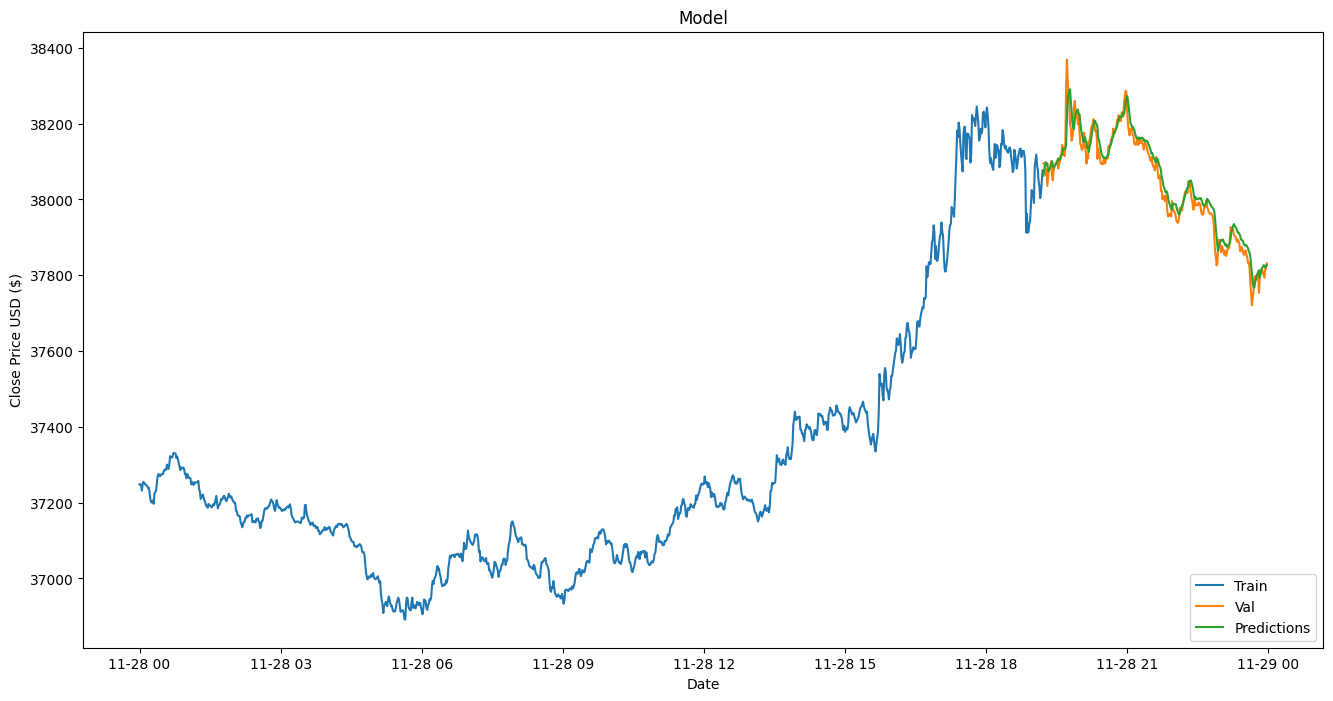

In [ ]:
#running standard lstm which consist of price history only

standard_lstm(ticker='btc-usd', start='2023-11-28', end='2023-11-29')

In [ ]:
# example passing own model

model = keras.Sequential()
model.add(layers.LSTM(10, return_sequences=True, input_shape=(5, 1)))
model.add(layers.LSTM(10, return_sequences=True))
model.add(layers.LSTM(5, return_sequences=False))
model.add(layers.Dense(100))
model.add(layers.Dense(5))
model.add(layers.Dense(1))

new_model = [None, model]

[*********************100%%**********************]  1 of 1 completed
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 5, 10)             480       
                                                                 
 lstm_36 (LSTM)              (None, 5, 10)             840       
                                                                 
 lstm_37 (LSTM)              (None, 5)                 320       
                                                                 
 dense_30 (Dense)            (None, 100)               600       
                                                                 
 dense_31 (Dense)            (None, 5)                 505       
                                                                 
 dense_32 (Dense)            (None, 1)                 6         
                                                  

<ipython-input-25-1b0830ccbc27>:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = self.predictions


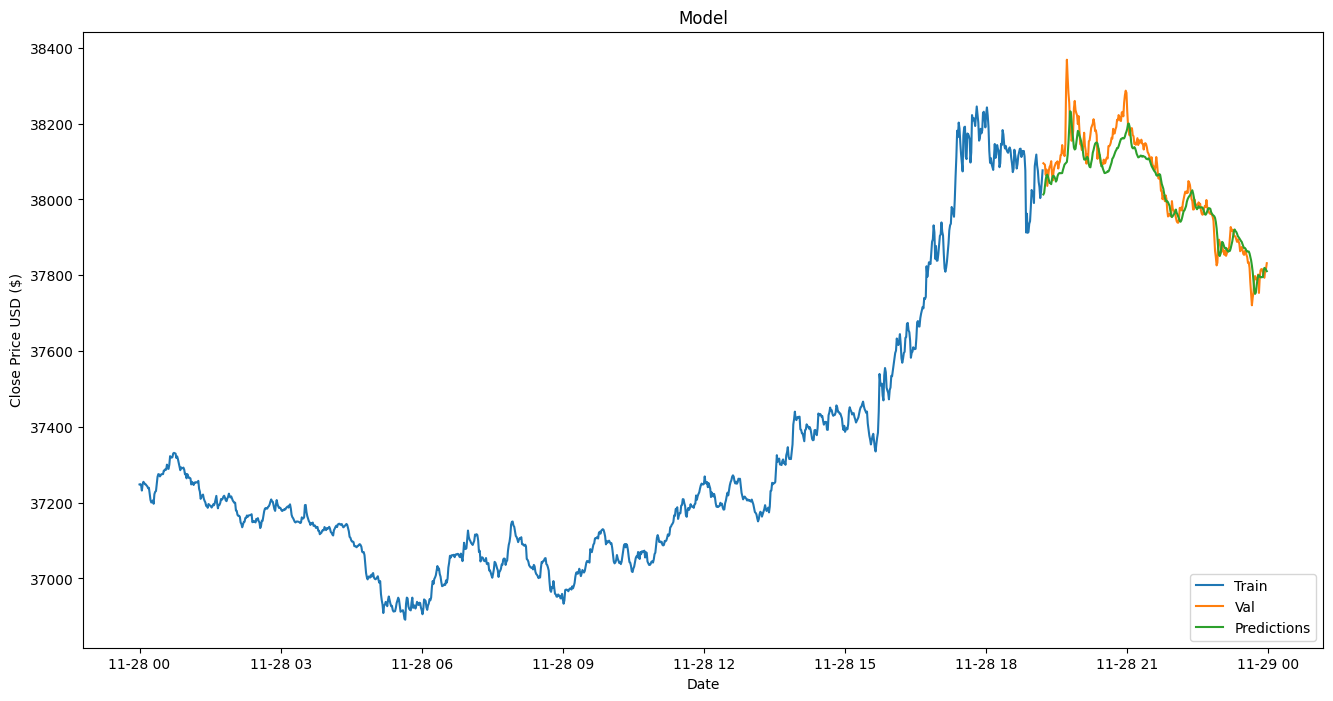

In [ ]:
standard_lstm('btc-usd', model=new_model)

In [ ]:
#dependancies are in 1st cell


def own_data_lstm(data_file_name, window_size=5, batch_size=1, epochs=4):
  'A function to run custom datasets through a hardcoded lstm, datasets obtained from dataset_builder-lstm'

  dataset = pd.read_csv(data_file_name)
  datetime = dataset.pop('Unnamed: 0')
  datetime.name = 'datetime'

  target = dataset.pop('price')
  dataset.set_index(datetime, inplace=True)
  print(dataset)

  window_size = window_size


  values = dataset.values
  target_values = target.values

  training_data_len = math.ceil(len(values)* 0.8)

  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_data = scaler.fit_transform(values)
  scaled_target = scaler.fit_transform(target_values.reshape(-1,1))

  train_data = scaled_data[0: training_data_len, :]
  target_data = scaled_target[0: training_data_len, :]

  x_train = []
  y_train = []

  for i in range(10, len(train_data)):
      x_train.append(train_data[i-window_size:i])
      y_train.append(target_data[i, 0])

  x_train, y_train = np.array(x_train), np.array(y_train)

  test_data = scaled_data[training_data_len-window_size: , : ]
  x_test = []
  y_test = target_values[training_data_len:]

  for i in range(window_size, len(test_data)):
    x_test.append(test_data[i-window_size:i])

  x_test = np.array(x_test)

        # model is hardcoded
  model = keras.Sequential()
  model.add(layers.LSTM(100, return_sequences=True, input_shape=x_test.shape[1:]))
  model.add(layers.LSTM(100, return_sequences=False))
  model.add(layers.Dense(25))
  model.add(layers.Dense(1))
  model.summary()

  model.compile(optimizer='adam', loss='mean_squared_error')
  model.fit(x_train, y_train, batch_size= batch_size, epochs=epochs)

  predictions = model.predict(x_test)
  predictions = scaler.inverse_transform(predictions)
  rmse = np.sqrt(np.mean(predictions - y_test)**2)
  print(f'\nrmse: {rmse}')

  data = target
  train = data[:training_data_len]
  validation = data[training_data_len:]
  plt.figure(figsize=(16,8))
  plt.title('Using own dataset of TA')
  plt.xlabel('Date')
  plt.ylabel('Close Price USD ($)')
  plt.plot(train)
  plt.plot(validation)

  predictions.resize(validation.shape)
  predictions = pd.DataFrame(data=predictions, index=validation.index)

  plt.plot(predictions)
  plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
  plt.show()


                     sma2_BTCUSDT  sma5_BTCUSDT  sma10_BTCUSDT  rsi14_BTCUSDT  \
datetime                                                                        
2023-11-28 00:32:00      0.291524      0.278510       0.274398       0.827726   
2023-11-28 00:33:00      0.292158      0.281462       0.275956       0.680393   
2023-11-28 00:34:00      0.285614      0.283158       0.277371       0.681757   
2023-11-28 00:35:00      0.290572      0.286922       0.279520       0.741374   
2023-11-28 00:36:00      0.290466      0.287178       0.280703       0.641863   
...                           ...           ...            ...            ...   
2023-11-28 23:55:00      0.671602      0.676373       0.675164       0.473853   
2023-11-28 23:56:00      0.670995      0.674325       0.675928       0.498941   
2023-11-28 23:57:00      0.678006      0.676093       0.676988       0.548348   
2023-11-28 23:58:00      0.684208      0.677385       0.680812       0.563887   
2023-11-28 23:59:00      0.6

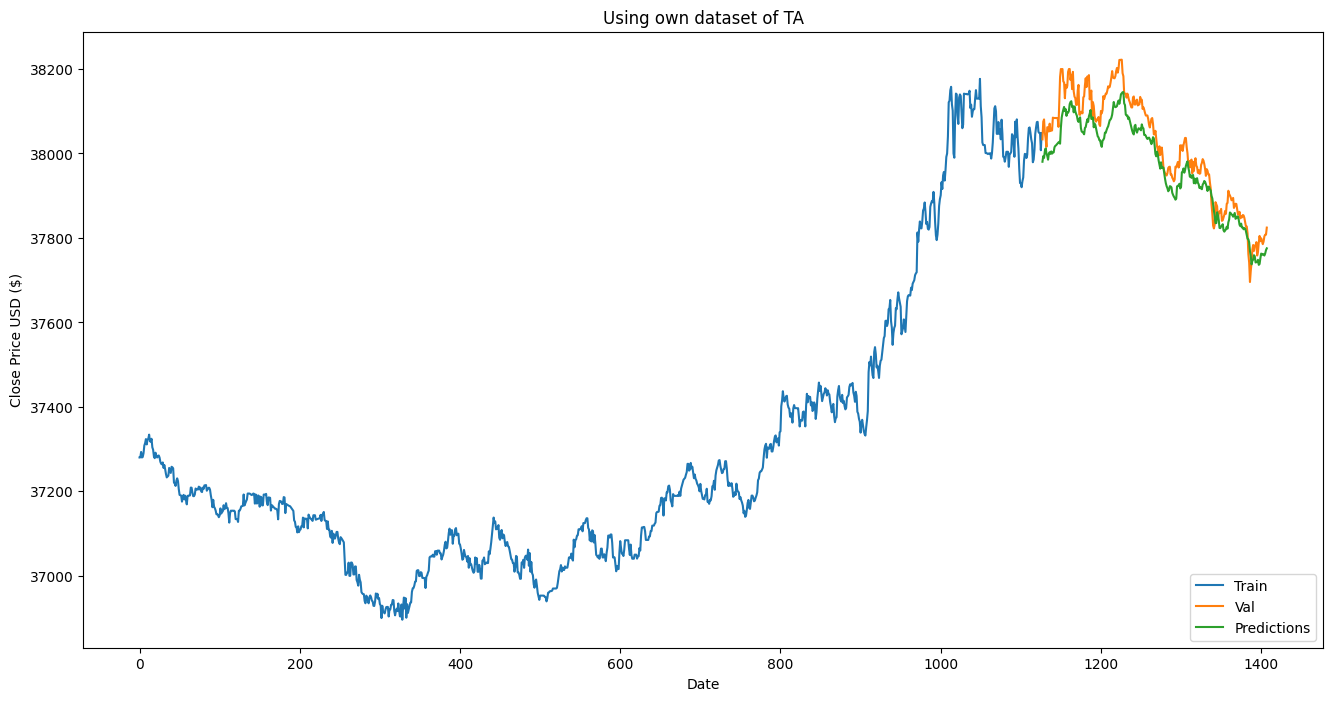

In [ ]:
own_data_lstm('lstm_data_v2.csv')